# Trabalho de Processamento de Imagens
## Aplicação de Filtros Espaciais para Redução de Ruído

**Disciplina:** Processamento de Imagens  
**Turma:** CC8NA  
**Período:** 2025.2  
**Professor:** Claudio Coutinho

---

## 1. Importação de Bibliotecas

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.stats import mode
import pandas as pd
import os

# Configurações de visualização
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


## 2. Funções Auxiliares

### 2.1 Funções de Geração de Ruído

In [2]:
def add_salt_pepper_noise(image, salt_prob=0.01, pepper_prob=0.01):
    """
    Adiciona ruído sal e pimenta à imagem.
    
    Args:
        image: Imagem de entrada
        salt_prob: Probabilidade de ruído sal (pixels brancos)
        pepper_prob: Probabilidade de ruído pimenta (pixels pretos)
    
    Returns:
        Imagem com ruído sal e pimenta
    """
    noisy = image.copy()
    
    # Ruído sal (branco)
    salt_mask = np.random.random(image.shape) < salt_prob
    noisy[salt_mask] = 255
    
    # Ruído pimenta (preto)
    pepper_mask = np.random.random(image.shape) < pepper_prob
    noisy[pepper_mask] = 0
    
    return noisy

def add_gaussian_noise(image, mean=0, sigma=25):
    """
    Adiciona ruído gaussiano à imagem.
    
    Args:
        image: Imagem de entrada
        mean: Média do ruído gaussiano
        sigma: Desvio padrão do ruído gaussiano
    
    Returns:
        Imagem com ruído gaussiano
    """
    gaussian = np.random.normal(mean, sigma, image.shape)
    noisy = image + gaussian
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)
    
    return noisy

### 2.2 Funções de Filtros Espaciais

In [3]:
def apply_mean_filter(image, kernel_size=3):
    """
    Aplica filtro de média.
    
    Args:
        image: Imagem de entrada
        kernel_size: Tamanho do kernel (3, 7, etc.)
    
    Returns:
        Imagem filtrada
    """
    return cv2.blur(image, (kernel_size, kernel_size))

def apply_gaussian_filter(image, kernel_size=3):
    """
    Aplica filtro gaussiano.
    
    Args:
        image: Imagem de entrada
        kernel_size: Tamanho do kernel (3, 7, etc.)
    
    Returns:
        Imagem filtrada
    """
    # Sigma calculado automaticamente baseado no tamanho do kernel
    sigma = 0.3 * ((kernel_size - 1) * 0.5 - 1) + 0.8
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)

def apply_median_filter(image, kernel_size=3):
    """
    Aplica filtro de mediana.
    
    Args:
        image: Imagem de entrada
        kernel_size: Tamanho do kernel (3, 7, etc.)
    
    Returns:
        Imagem filtrada
    """
    return cv2.medianBlur(image, kernel_size)

def apply_mode_filter(image, kernel_size=3):
    """
    Aplica filtro de moda.
    
    Args:
        image: Imagem de entrada
        kernel_size: Tamanho do kernel (3, 7, etc.)
    
    Returns:
        Imagem filtrada
    """
    # Implementação manual do filtro de moda
    pad = kernel_size // 2
    padded = np.pad(image, pad, mode='edge')
    output = np.zeros_like(image)
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            window = padded[i:i+kernel_size, j:j+kernel_size]
            output[i, j] = mode(window, axis=None, keepdims=False)[0]
    
    return output.astype(np.uint8)

### 2.3 Funções de Avaliação Quantitativa

In [4]:
def calculate_mse(original, filtered):
    """
    Calcula o Mean Squared Error (MSE) entre duas imagens.
    
    Args:
        original: Imagem original (referência)
        filtered: Imagem filtrada
    
    Returns:
        Valor do MSE
    """
    mse = np.mean((original.astype(float) - filtered.astype(float)) ** 2)
    return mse

def calculate_psnr(original, filtered):
    """
    Calcula o Peak Signal-to-Noise Ratio (PSNR) entre duas imagens.
    
    Args:
        original: Imagem original (referência)
        filtered: Imagem filtrada
    
    Returns:
        Valor do PSNR em dB
    """
    mse = calculate_mse(original, filtered)
    if mse == 0:
        return float('inf')
    
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

### 2.4 Função para Processar Imagem com Todos os Filtros

In [5]:
def process_image_with_filters(original, noisy):
    """
    Processa uma imagem aplicando todos os filtros e calcula as métricas.
    
    Args:
        original: Imagem original sem ruído
        noisy: Imagem com ruído
    
    Returns:
        Dictionary com imagens filtradas e métricas
    """
    results = {}
    
    # Lista de filtros a aplicar
    filters = [
        ('Média 3x3', apply_mean_filter, 3),
        ('Média 7x7', apply_mean_filter, 7),
        ('Gaussiano 3x3', apply_gaussian_filter, 3),
        ('Gaussiano 7x7', apply_gaussian_filter, 7),
        ('Mediana 3x3', apply_median_filter, 3),
        ('Mediana 7x7', apply_median_filter, 7),
        ('Moda 3x3', apply_mode_filter, 3),
        ('Moda 7x7', apply_mode_filter, 7),
    ]
    
    for filter_name, filter_func, kernel_size in filters:
        # Aplicar filtro
        filtered = filter_func(noisy, kernel_size)
        
        # Calcular métricas
        mse = calculate_mse(original, filtered)
        psnr = calculate_psnr(original, filtered)
        
        results[filter_name] = {
            'image': filtered,
            'mse': mse,
            'psnr': psnr
        }
    
    return results

## 3. Carregamento e Preparação das Imagens

**Instruções:** 
1. Coloque suas 3 imagens na pasta `images/`
2. Atualize os nomes dos arquivos na célula abaixo

In [6]:
# Criar pasta para imagens se não existir
os.makedirs('images', exist_ok=True)
os.makedirs('results', exist_ok=True)

# ATUALIZE AQUI com os nomes das suas imagens
image_files = [
    'images/imagem1.jpg',
    'images/imagem2.jpg',
    'images/imagem3.jpg'
]

# Carregar e converter para tons de cinza
original_images = []

for img_path in image_files:
    if os.path.exists(img_path):
        # Carregar imagem
        img = cv2.imread(img_path)
        # Converter para tons de cinza
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        original_images.append(gray)
        print(f"Carregada: {img_path} - Shape: {gray.shape}")
    else:
        print(f"AVISO: Arquivo não encontrado: {img_path}")

if len(original_images) == 0:
    print("\n⚠️ NENHUMA IMAGEM ENCONTRADA!")
    print("Por favor, adicione 3 imagens na pasta 'images/' e atualize os nomes na célula acima.")
else:
    print(f"\n✓ {len(original_images)} imagem(ns) carregada(s) com sucesso!")

Carregada: images/imagem1.jpg - Shape: (1472, 828)
Carregada: images/imagem2.jpg - Shape: (1472, 828)
Carregada: images/imagem3.jpg - Shape: (1472, 828)

✓ 3 imagem(ns) carregada(s) com sucesso!


## 4. Geração de Ruído

**Escolha o tipo de ruído:** Descomente a linha do ruído desejado

In [7]:
# Tipo de ruído a aplicar
NOISE_TYPE = 'salt_pepper'  # Opções: 'salt_pepper' ou 'gaussian'

noisy_images = []

for i, img in enumerate(original_images):
    if NOISE_TYPE == 'salt_pepper':
        noisy = add_salt_pepper_noise(img, salt_prob=0.02, pepper_prob=0.02)
        print(f"Imagem {i+1}: Ruído sal e pimenta aplicado (4% de pixels afetados)")
    else:  # gaussian
        noisy = add_gaussian_noise(img, mean=0, sigma=25)
        print(f"Imagem {i+1}: Ruído gaussiano aplicado (sigma=25)")
    
    noisy_images.append(noisy)

print(f"\n✓ Ruído aplicado a {len(noisy_images)} imagem(ns)!")

Imagem 1: Ruído sal e pimenta aplicado (4% de pixels afetados)
Imagem 2: Ruído sal e pimenta aplicado (4% de pixels afetados)
Imagem 3: Ruído sal e pimenta aplicado (4% de pixels afetados)

✓ Ruído aplicado a 3 imagem(ns)!


### Visualização: Original vs Ruidosa

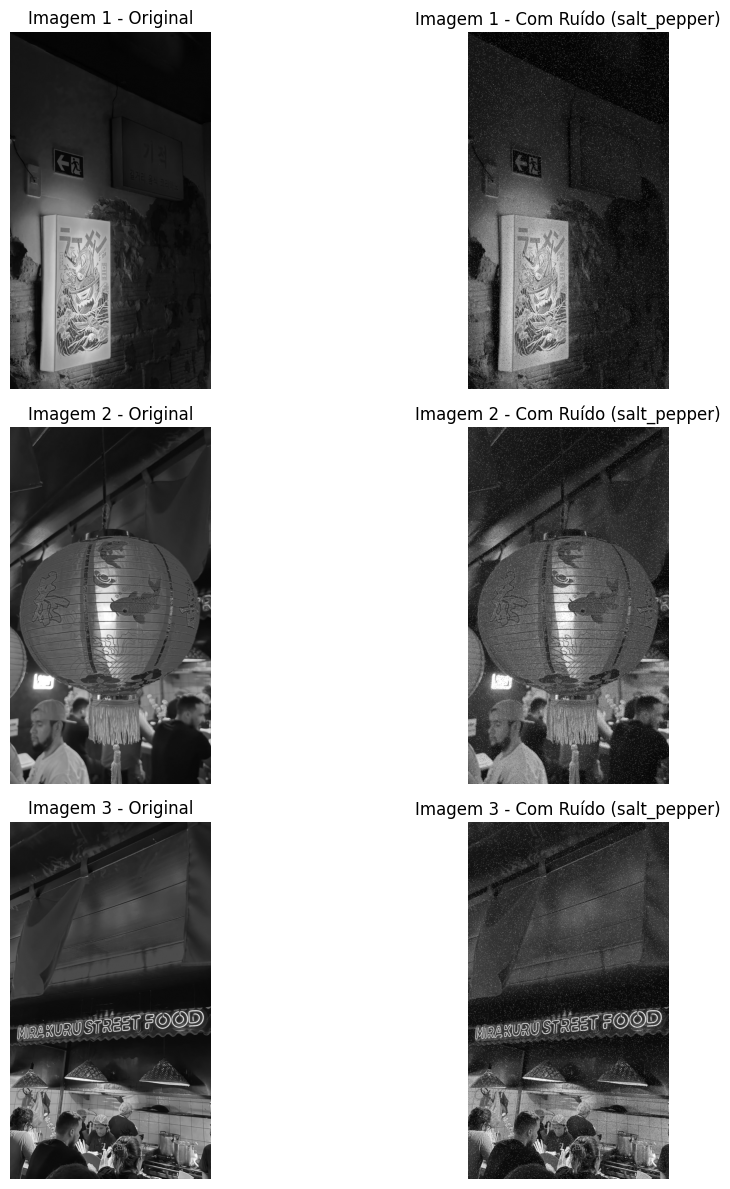

In [8]:
if len(original_images) > 0:
    fig, axes = plt.subplots(len(original_images), 2, figsize=(12, 4*len(original_images)))
    
    if len(original_images) == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(len(original_images)):
        axes[i, 0].imshow(original_images[i], cmap='gray', vmin=0, vmax=255)
        axes[i, 0].set_title(f'Imagem {i+1} - Original')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(noisy_images[i], cmap='gray', vmin=0, vmax=255)
        axes[i, 1].set_title(f'Imagem {i+1} - Com Ruído ({NOISE_TYPE})')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.savefig('results/comparacao_original_ruido.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Nenhuma imagem para visualizar.")

## 5. Aplicação de Filtros e Cálculo de Métricas

In [9]:
# Processar todas as imagens
all_results = []

for i, (original, noisy) in enumerate(zip(original_images, noisy_images)):
    print(f"Processando Imagem {i+1}...")
    results = process_image_with_filters(original, noisy)
    all_results.append(results)             
    print(f"  ✓ {len(results)} filtros aplicados")

print(f"\n✓ Processamento completo!")

Processando Imagem 1...
  ✓ 8 filtros aplicados
Processando Imagem 2...
  ✓ 8 filtros aplicados
Processando Imagem 3...
  ✓ 8 filtros aplicados

✓ Processamento completo!


## 6. Resultados - Tabelas de MSE e PSNR

In [10]:
# Criar tabelas para cada imagem
for i, results in enumerate(all_results):
    print(f"\n{'='*60}")
    print(f"IMAGEM {i+1} - Resultados Quantitativos")
    print(f"{'='*60}")
    
    # Criar DataFrame
    data = []
    for filter_name, metrics in results.items():
        data.append({
            'Filtro': filter_name,
            'MSE': f"{metrics['mse']:.4f}",
            'PSNR (dB)': f"{metrics['psnr']:.4f}"
        })
    
    df = pd.DataFrame(data)
    print(df.to_string(index=False))
    
    # Salvar tabela em CSV
    df.to_csv(f'results/metricas_imagem_{i+1}.csv', index=False)
    
    # Encontrar melhor filtro
    best_filter = min(results.items(), key=lambda x: x[1]['mse'])
    print(f"\n✓ Melhor filtro (menor MSE): {best_filter[0]}")
    print(f"  MSE = {best_filter[1]['mse']:.4f}")
    print(f"  PSNR = {best_filter[1]['psnr']:.4f} dB")


IMAGEM 1 - Resultados Quantitativos
       Filtro      MSE PSNR (dB)
    Média 3x3 155.8505   26.2037
    Média 7x7 132.5445   26.9072
Gaussiano 3x3 179.6442   25.5867
Gaussiano 7x7 111.7089   27.6499
  Mediana 3x3  26.2128   33.9457
  Mediana 7x7  90.7365   28.5530
     Moda 3x3 400.3421   22.1065
     Moda 7x7 356.1198   22.6148

✓ Melhor filtro (menor MSE): Mediana 3x3
  MSE = 26.2128
  PSNR = 33.9457 dB

IMAGEM 2 - Resultados Quantitativos
       Filtro      MSE PSNR (dB)
    Média 3x3 133.0705   26.8900
    Média 7x7 135.3043   26.8177
Gaussiano 3x3 153.0445   26.2826
Gaussiano 7x7  99.5110   28.1521
  Mediana 3x3  20.8823   34.9330
  Mediana 7x7 105.3556   27.9042
     Moda 3x3 444.2238   21.6548
     Moda 7x7 393.2625   22.1840

✓ Melhor filtro (menor MSE): Mediana 3x3
  MSE = 20.8823
  PSNR = 34.9330 dB

IMAGEM 3 - Resultados Quantitativos
       Filtro      MSE PSNR (dB)
    Média 3x3 164.9432   25.9575
    Média 7x7 267.9296   23.8506
Gaussiano 3x3 176.1462   25.6721
Gaussia

### Tabela Média de Todas as Imagens

In [11]:
if len(all_results) > 0:
    print(f"\n{'='*60}")
    print("MÉDIA DE TODAS AS IMAGENS")
    print(f"{'='*60}")
    
    # Calcular médias
    filter_names = list(all_results[0].keys())
    avg_data = []
    
    for filter_name in filter_names:
        avg_mse = np.mean([result[filter_name]['mse'] for result in all_results])
        avg_psnr = np.mean([result[filter_name]['psnr'] for result in all_results])
        
        avg_data.append({
            'Filtro': filter_name,
            'MSE Médio': f"{avg_mse:.4f}",
            'PSNR Médio (dB)': f"{avg_psnr:.4f}"
        })
    
    df_avg = pd.DataFrame(avg_data)
    print(df_avg.to_string(index=False))
    
    # Salvar tabela média
    df_avg.to_csv('results/metricas_media.csv', index=False)
    
    # Melhor filtro na média
    best_idx = df_avg['MSE Médio'].astype(float).idxmin()
    print(f"\n✓ Melhor filtro na média: {df_avg.loc[best_idx, 'Filtro']}")
    print(f"  MSE Médio = {df_avg.loc[best_idx, 'MSE Médio']}")
    print(f"  PSNR Médio = {df_avg.loc[best_idx, 'PSNR Médio (dB)']} dB")


MÉDIA DE TODAS AS IMAGENS
       Filtro MSE Médio PSNR Médio (dB)
    Média 3x3  151.2881         26.3504
    Média 7x7  178.5928         25.8585
Gaussiano 3x3  169.6116         25.8471
Gaussiano 7x7  123.7178         27.2978
  Mediana 3x3   26.5119         33.9662
  Mediana 7x7  131.4637         27.2049
     Moda 3x3  476.7476         21.4052
     Moda 7x7  471.3018         21.5682

✓ Melhor filtro na média: Mediana 3x3
  MSE Médio = 26.5119
  PSNR Médio = 33.9662 dB


## 7. Visualização Comparativa

### 7.1 Comparação Completa (Primeira Imagem)

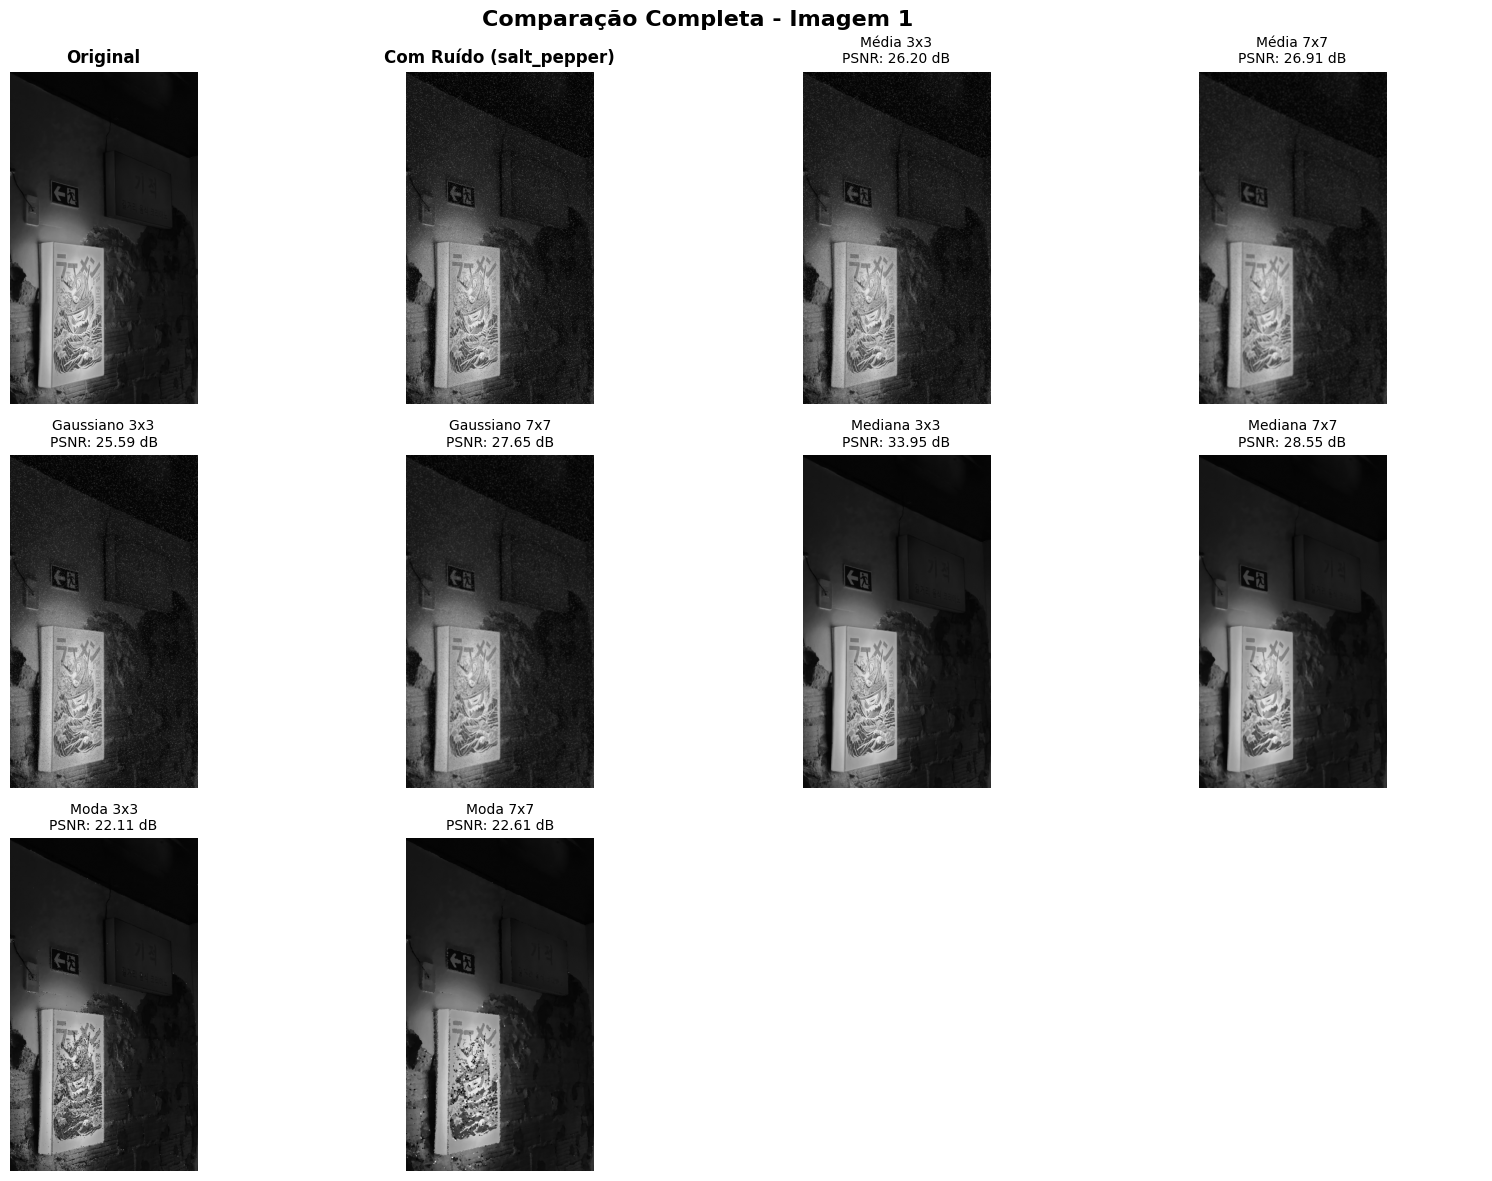

In [12]:
if len(all_results) > 0:
    # Mostrar comparação da primeira imagem
    img_idx = 0
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()
    
    # Original
    axes[0].imshow(original_images[img_idx], cmap='gray', vmin=0, vmax=255)
    axes[0].set_title('Original', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Ruidosa
    axes[1].imshow(noisy_images[img_idx], cmap='gray', vmin=0, vmax=255)
    axes[1].set_title(f'Com Ruído ({NOISE_TYPE})', fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    # Filtros
    filter_names = list(all_results[img_idx].keys())
    for i, filter_name in enumerate(filter_names):
        filtered_img = all_results[img_idx][filter_name]['image']
        psnr = all_results[img_idx][filter_name]['psnr']
        
        axes[i+2].imshow(filtered_img, cmap='gray', vmin=0, vmax=255)
        axes[i+2].set_title(f'{filter_name}\nPSNR: {psnr:.2f} dB', fontsize=10)
        axes[i+2].axis('off')
    
    # Desativar eixos extras
    for i in range(len(filter_names)+2, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(f'Comparação Completa - Imagem 1', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('results/comparacao_completa_imagem1.png', dpi=150, bbox_inches='tight')
    plt.show()

### 7.2 Comparação Selecionada (Para Relatório)

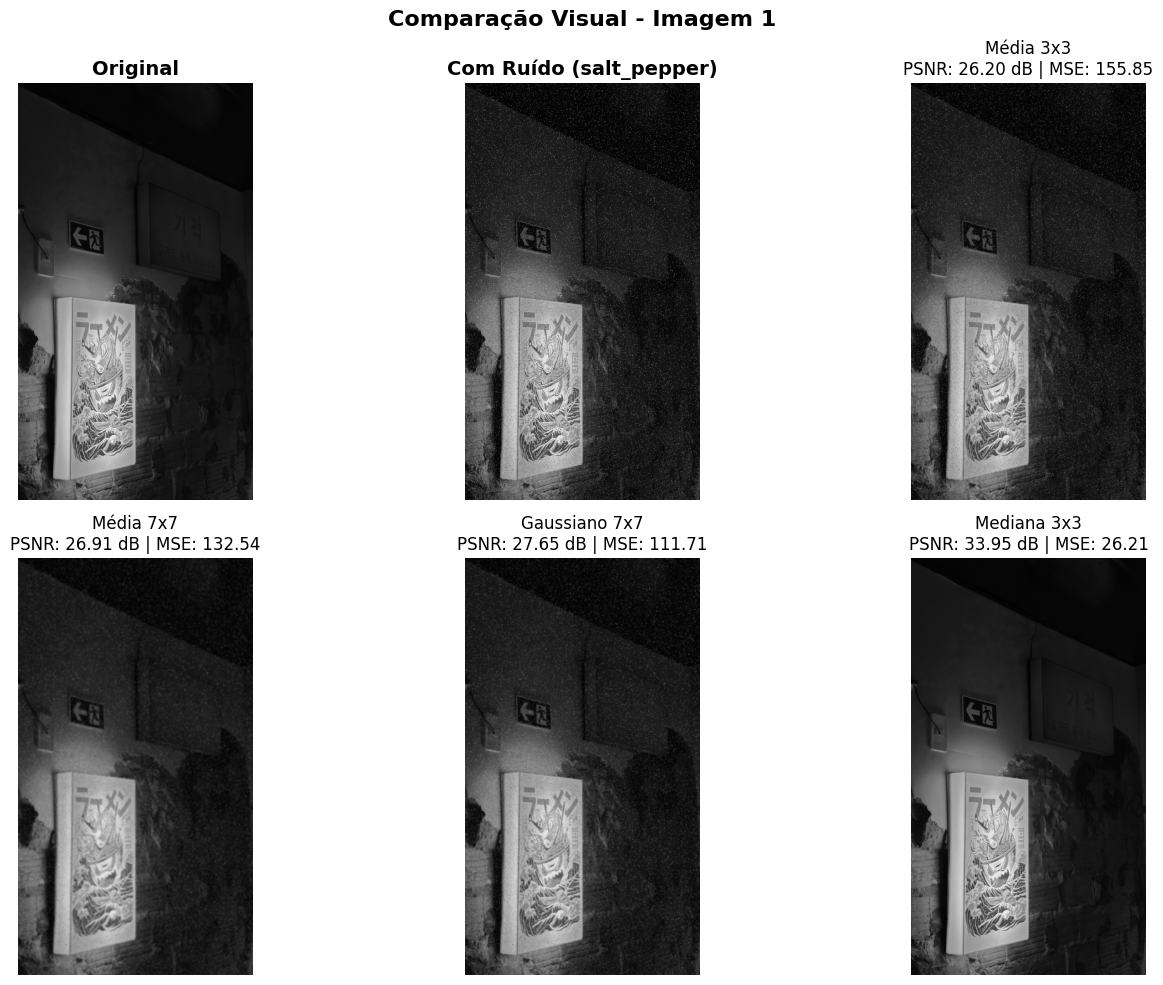

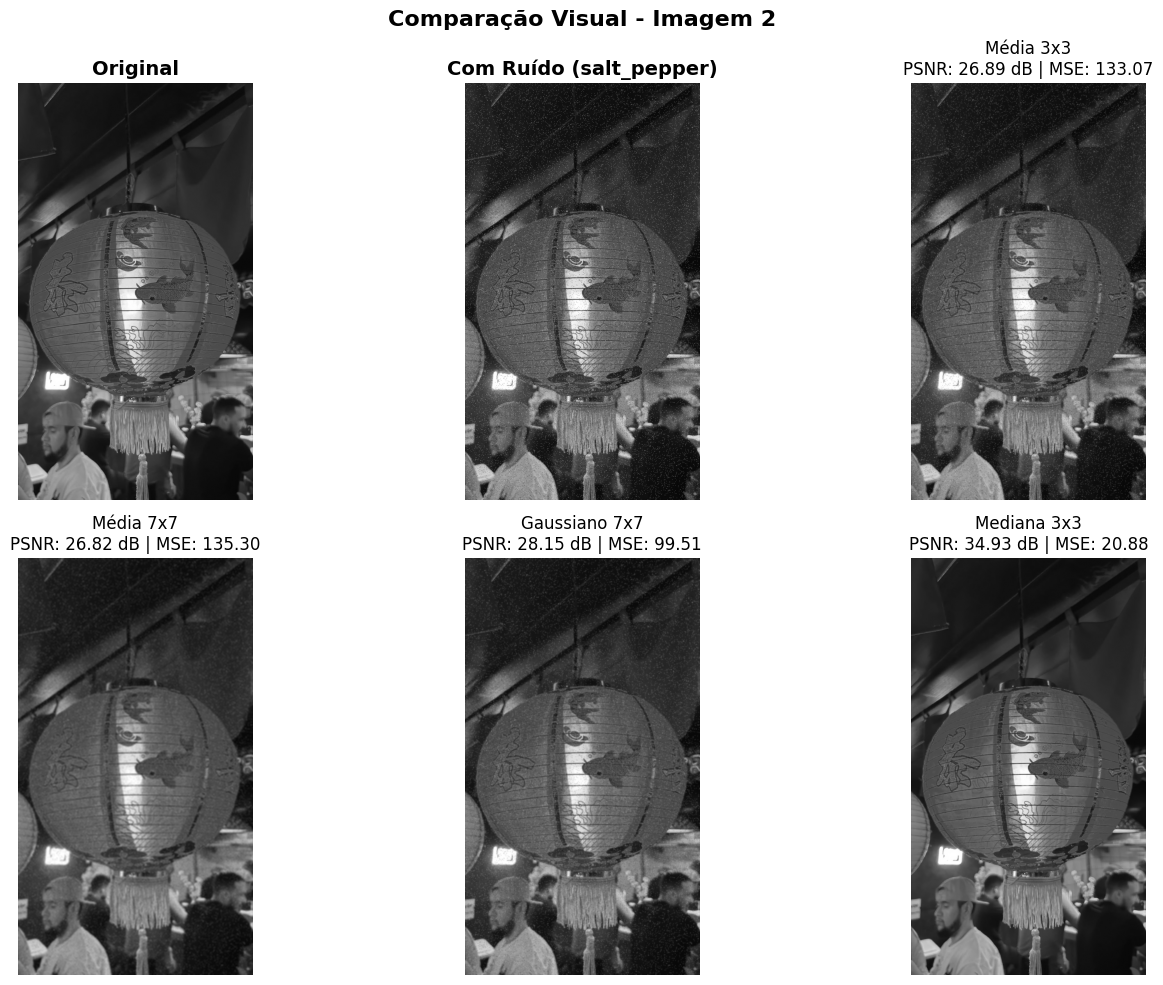

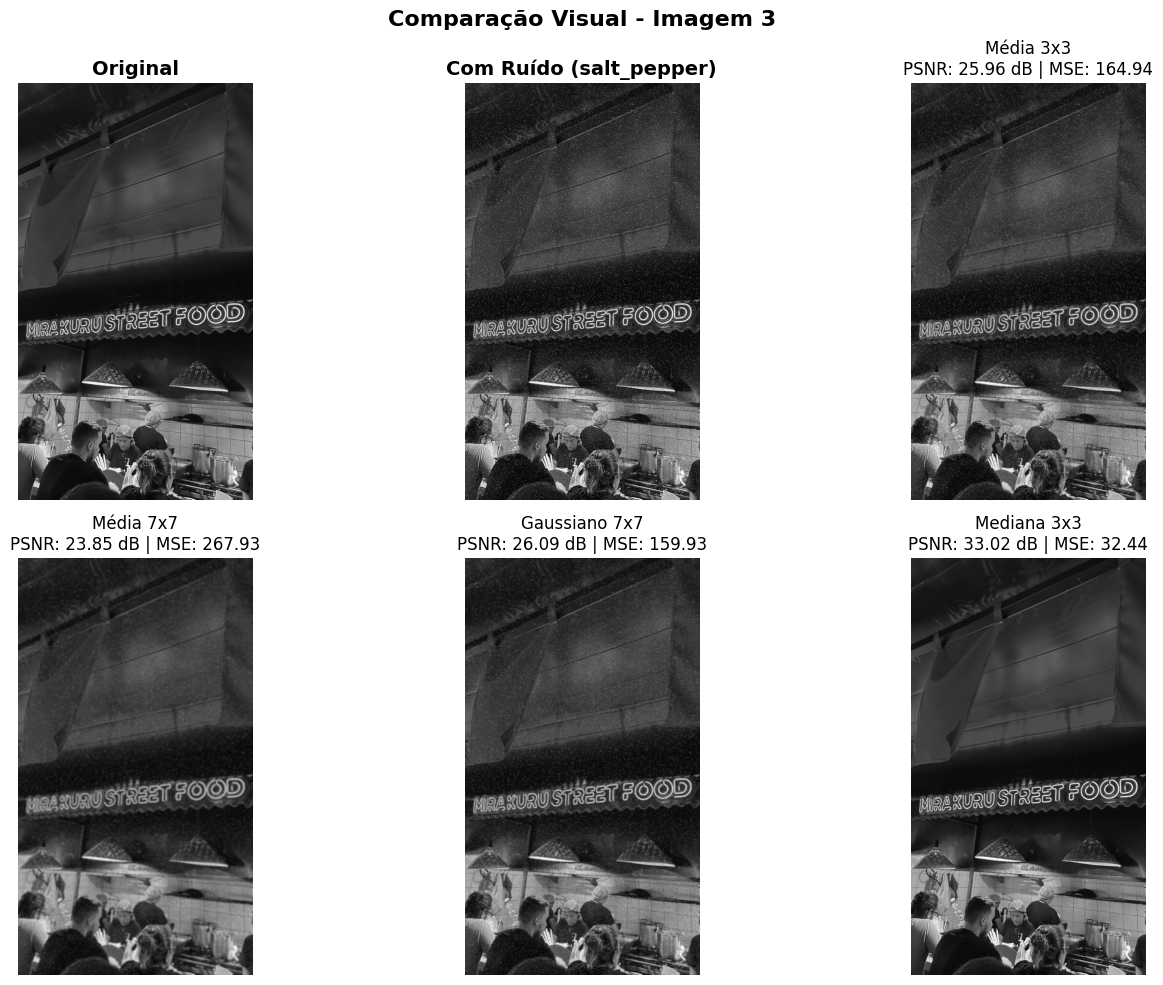

In [13]:
if len(all_results) > 0:
    # Selecionar filtros representativos para o relatório
    selected_filters = ['Média 3x3', 'Média 7x7', 'Gaussiano 7x7', 'Mediana 3x3']
    
    for img_idx in range(len(all_results)):
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()
        
        # Original
        axes[0].imshow(original_images[img_idx], cmap='gray', vmin=0, vmax=255)
        axes[0].set_title('Original', fontsize=14, fontweight='bold')
        axes[0].axis('off')
        
        # Ruidosa
        axes[1].imshow(noisy_images[img_idx], cmap='gray', vmin=0, vmax=255)
        axes[1].set_title(f'Com Ruído ({NOISE_TYPE})', fontsize=14, fontweight='bold')
        axes[1].axis('off')
        
        # Filtros selecionados
        for i, filter_name in enumerate(selected_filters):
            if filter_name in all_results[img_idx]:
                filtered_img = all_results[img_idx][filter_name]['image']
                psnr = all_results[img_idx][filter_name]['psnr']
                mse = all_results[img_idx][filter_name]['mse']
                
                axes[i+2].imshow(filtered_img, cmap='gray', vmin=0, vmax=255)
                axes[i+2].set_title(f'{filter_name}\nPSNR: {psnr:.2f} dB | MSE: {mse:.2f}', 
                                   fontsize=12)
                axes[i+2].axis('off')
        
        plt.suptitle(f'Comparação Visual - Imagem {img_idx+1}', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'results/comparacao_relatorio_imagem{img_idx+1}.png', dpi=150, bbox_inches='tight')
        plt.show()

## 8. Gráficos de Análise

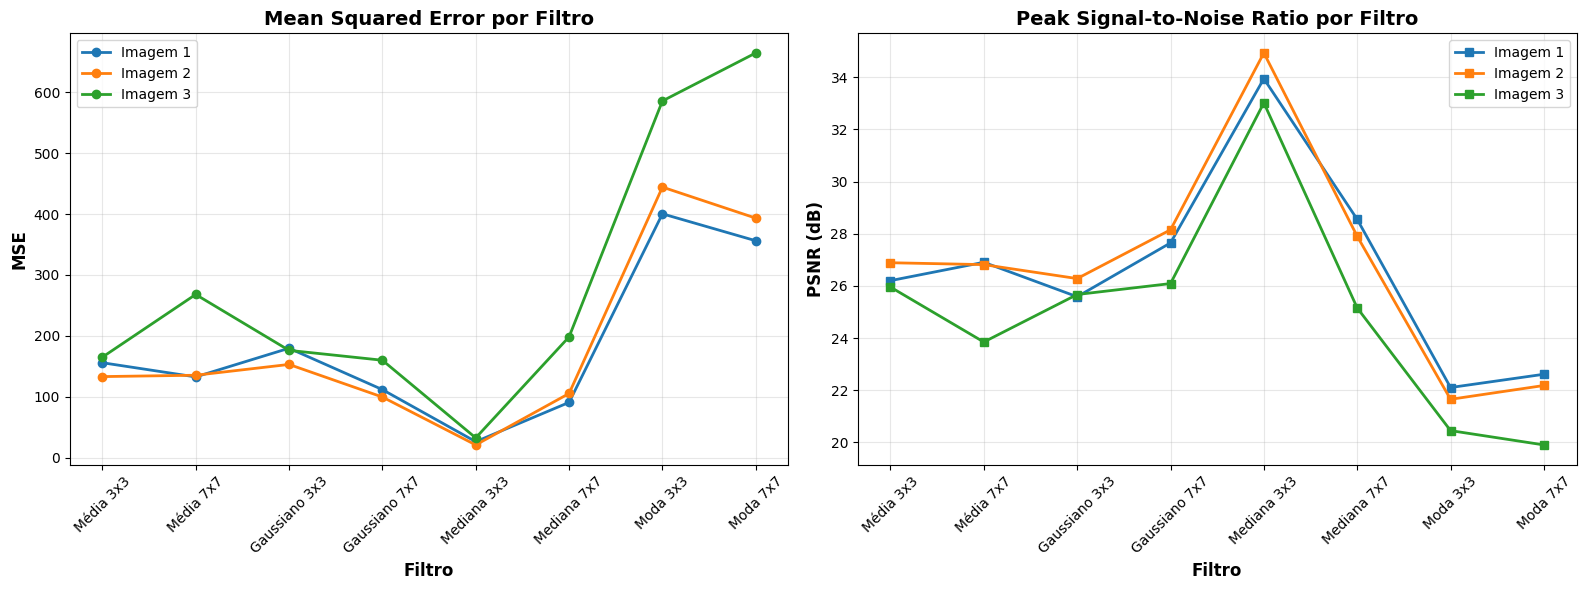

In [14]:
if len(all_results) > 0:
    # Preparar dados para gráfico
    filter_names = list(all_results[0].keys())
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Gráfico de MSE
    for img_idx in range(len(all_results)):
        mse_values = [all_results[img_idx][f]['mse'] for f in filter_names]
        ax1.plot(filter_names, mse_values, marker='o', label=f'Imagem {img_idx+1}', linewidth=2)
    
    ax1.set_xlabel('Filtro', fontsize=12, fontweight='bold')
    ax1.set_ylabel('MSE', fontsize=12, fontweight='bold')
    ax1.set_title('Mean Squared Error por Filtro', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Gráfico de PSNR
    for img_idx in range(len(all_results)):
        psnr_values = [all_results[img_idx][f]['psnr'] for f in filter_names]
        ax2.plot(filter_names, psnr_values, marker='s', label=f'Imagem {img_idx+1}', linewidth=2)
    
    ax2.set_xlabel('Filtro', fontsize=12, fontweight='bold')
    ax2.set_ylabel('PSNR (dB)', fontsize=12, fontweight='bold')
    ax2.set_title('Peak Signal-to-Noise Ratio por Filtro', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('results/graficos_metricas.png', dpi=150, bbox_inches='tight')
    plt.show()

## 9. Análise Comparativa: Kernel 3x3 vs 7x7

In [15]:
if len(all_results) > 0:
    print(f"\n{'='*60}")
    print("ANÁLISE: Kernel 3x3 vs 7x7")
    print(f"{'='*60}\n")
    
    filter_types = ['Média', 'Gaussiano', 'Mediana', 'Moda']
    
    for filter_type in filter_types:
        filter_3x3 = f"{filter_type} 3x3"
        filter_7x7 = f"{filter_type} 7x7"
        
        # Calcular médias
        avg_mse_3x3 = np.mean([r[filter_3x3]['mse'] for r in all_results])
        avg_mse_7x7 = np.mean([r[filter_7x7]['mse'] for r in all_results])
        avg_psnr_3x3 = np.mean([r[filter_3x3]['psnr'] for r in all_results])
        avg_psnr_7x7 = np.mean([r[filter_7x7]['psnr'] for r in all_results])
        
        print(f"{filter_type}:")
        print(f"  3x3: MSE={avg_mse_3x3:.4f} | PSNR={avg_psnr_3x3:.4f} dB")
        print(f"  7x7: MSE={avg_mse_7x7:.4f} | PSNR={avg_psnr_7x7:.4f} dB")
        
        if avg_mse_3x3 < avg_mse_7x7:
            print(f"  → 3x3 teve melhor desempenho (menor MSE)")
        else:
            print(f"  → 7x7 teve melhor desempenho (menor MSE)")
        print()


ANÁLISE: Kernel 3x3 vs 7x7

Média:
  3x3: MSE=151.2881 | PSNR=26.3504 dB
  7x7: MSE=178.5928 | PSNR=25.8585 dB
  → 3x3 teve melhor desempenho (menor MSE)

Gaussiano:
  3x3: MSE=169.6116 | PSNR=25.8471 dB
  7x7: MSE=123.7178 | PSNR=27.2978 dB
  → 7x7 teve melhor desempenho (menor MSE)

Mediana:
  3x3: MSE=26.5119 | PSNR=33.9662 dB
  7x7: MSE=131.4637 | PSNR=27.2049 dB
  → 3x3 teve melhor desempenho (menor MSE)

Moda:
  3x3: MSE=476.7476 | PSNR=21.4052 dB
  7x7: MSE=471.3018 | PSNR=21.5682 dB
  → 7x7 teve melhor desempenho (menor MSE)



## 10. Salvar Imagens Filtradas

In [16]:
# Salvar todas as imagens filtradas
for img_idx, results in enumerate(all_results):
    # Criar pasta para esta imagem
    img_folder = f'results/imagem_{img_idx+1}'
    os.makedirs(img_folder, exist_ok=True)
    
    # Salvar original e ruidosa
    cv2.imwrite(f'{img_folder}/original.png', original_images[img_idx])
    cv2.imwrite(f'{img_folder}/ruidosa.png', noisy_images[img_idx])
    
    # Salvar filtradas
    for filter_name, data in results.items():
        filename = filter_name.lower().replace(' ', '_').replace('x', '')
        cv2.imwrite(f'{img_folder}/{filename}.png', data['image'])
    
    print(f"✓ Imagem {img_idx+1}: {len(results)+2} arquivos salvos em '{img_folder}/'")

print("\n✓ Todas as imagens foram salvas!")

✓ Imagem 1: 10 arquivos salvos em 'results/imagem_1/'
✓ Imagem 2: 10 arquivos salvos em 'results/imagem_2/'
✓ Imagem 3: 10 arquivos salvos em 'results/imagem_3/'

✓ Todas as imagens foram salvas!


## 11. Resumo Final

In [17]:
if len(all_results) > 0:
    print("\n" + "="*70)
    print(" "*20 + "RESUMO FINAL DO PROCESSAMENTO")
    print("="*70)
    
    print(f"\n📊 Estatísticas Gerais:")
    print(f"  • Número de imagens processadas: {len(all_results)}")
    print(f"  • Tipo de ruído aplicado: {NOISE_TYPE}")
    print(f"  • Número de filtros testados: {len(all_results[0])}")
    
    # Melhor filtro geral
    filter_names = list(all_results[0].keys())
    avg_mse_per_filter = {}
    
    for filter_name in filter_names:
        avg_mse = np.mean([r[filter_name]['mse'] for r in all_results])
        avg_mse_per_filter[filter_name] = avg_mse
    
    best_filter = min(avg_mse_per_filter.items(), key=lambda x: x[1])
    worst_filter = max(avg_mse_per_filter.items(), key=lambda x: x[1])
    
    print(f"\n🏆 Melhor filtro (média de todas as imagens):")
    print(f"  • {best_filter[0]}")
    print(f"  • MSE médio: {best_filter[1]:.4f}")
    
    # Calcular PSNR do melhor
    best_psnr = np.mean([r[best_filter[0]]['psnr'] for r in all_results])
    print(f"  • PSNR médio: {best_psnr:.4f} dB")
    
    print(f"\n📁 Arquivos gerados:")
    print(f"  • Tabelas CSV em: results/metricas_*.csv")
    print(f"  • Figuras em: results/*.png")
    print(f"  • Imagens filtradas em: results/imagem_*/")
    
    print("\n" + "="*70)
    print(" "*15 + "✓ PROCESSAMENTO CONCLUÍDO COM SUCESSO!")
    print("="*70 + "\n")
else:
    print("\n⚠️ Nenhuma imagem foi processada. Adicione imagens e execute novamente.")


                    RESUMO FINAL DO PROCESSAMENTO

📊 Estatísticas Gerais:
  • Número de imagens processadas: 3
  • Tipo de ruído aplicado: salt_pepper
  • Número de filtros testados: 8

🏆 Melhor filtro (média de todas as imagens):
  • Mediana 3x3
  • MSE médio: 26.5119
  • PSNR médio: 33.9662 dB

📁 Arquivos gerados:
  • Tabelas CSV em: results/metricas_*.csv
  • Figuras em: results/*.png
  • Imagens filtradas em: results/imagem_*/

               ✓ PROCESSAMENTO CONCLUÍDO COM SUCESSO!

